## Advanced Lane Finding
### In this project, the goal is to write a software pipeline to identify the lane boundaries in a video

![Lanes Image](./output_images/giphy.gif)



Main notebook 
---

The goals / steps of this project are the following:

* The camera calibration 
* Apply a distortion correction to raw images.
* Create a thresholded binary image.
* Apply a perspective transform ("birds-eye view").
* Detect lane pixels 

### Pipeline

* Determine the curvature and vehicle position with respect to center.
* Draw in the image the detected lines
* Output visual display

The images for camera calibration are stored in the folder called `camera_cal/`.  The images in `test_images/` are for testing the pipeline on single frames. 

The `challenge_video.mp4` video is an extra (and optional) challenge 
The `harder_challenge.mp4` video is another optional challenge and is brutal!

# libraries 

In [1]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 

# The camera calibration 

In [2]:
#run this piece of code to make the pipeline work
# object points

nx = 9 # number of corners in x direction
ny = 6 # number of corners in Y direction
# i take this from : #############################################################################################
#https://medium.com/@omar.ps16/stereo-3d-reconstruction-with-opencv-using-an-iphone-camera-part-ii-77754b58bfe0 ##
objp = np.zeros((np.prod(nx*ny),3),dtype=np.float32)  ############################################################
objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)     ########
##############################################################
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in images:
        
    img = cv2.imread(fname)
    # Converting an image, imported by cv2 or the glob API, to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp) #<--- the important we will use later:D 
        imgpoints.append(corners) #<--- the important we will use later:D


In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # calibrate camera 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    
    # Undistorting the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist

# Apply a distortion correction to raw images.

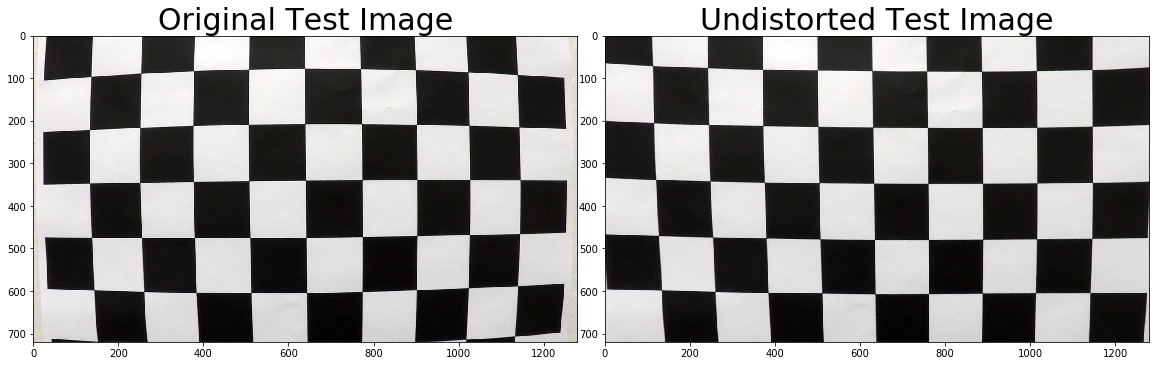

In [4]:
#test
# Read a image
img = mpimg.imread("camera_cal/calibration1.jpg")
# Undistorting the  image
und_img = cal_undistort(img, objpoints, imgpoints)


# Plot Original and Undistorted Image
plt.figure(figsize=(20,50))
plt.subplots_adjust(hspace = .2, wspace=.05)

# Plot Original Image
plt.subplot(1,2,1)
plt.title('Original Test Image', fontsize=30)
fig =plt.imshow(img)

# Plot Undistorted Image
plt.subplot(1,2,2)
plt.title('Undistorted Test Image', fontsize=30)
fig =plt.imshow(und_img)


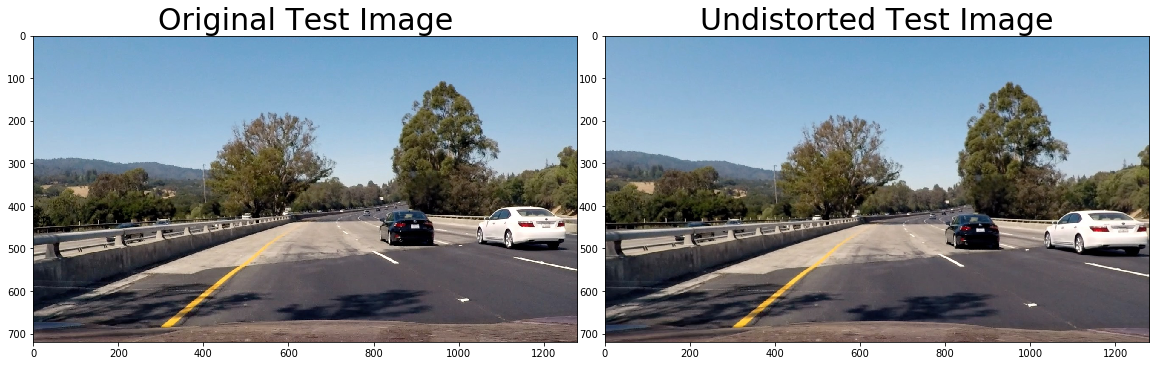

In [5]:
folder = "test_images/photos/"
# Read a image
img = mpimg.imread(folder + 'test4.jpg')
# Undistorting the  image
und_img = cal_undistort(img, objpoints, imgpoints)


# Plot Original and Undistorted Image
plt.figure(figsize=(20,50))
plt.subplots_adjust(hspace = .2, wspace=.05)

# Plot Original Image
plt.subplot(1,2,1)
plt.title('Original Test Image', fontsize=30)
fig =plt.imshow(img)

# Plot Undistorted Image
plt.subplot(1,2,2)
plt.title('Undistorted Test Image', fontsize=30)
fig =plt.imshow(und_img)


# Create a thresholded binary image.

In [6]:
###############################################################
##################### ABS SOBEL THRESH ########################
###############################################################
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output
###############################################################
######################## MAG THRESH ###########################
###############################################################
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output
###############################################################
###################### DIR THRESHOLD ##########################
###############################################################
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
#############################################################################
########################### HLS SELECT ######################################
#############################################################################
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

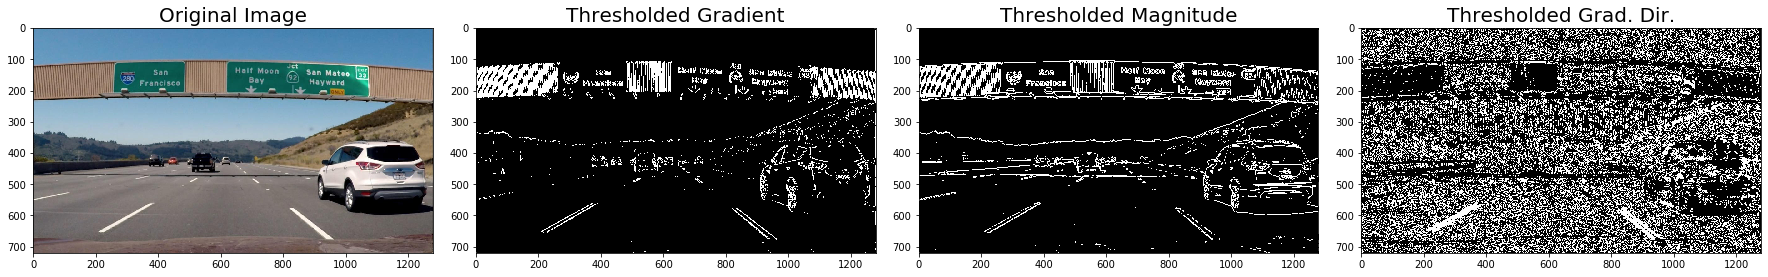

In [7]:
#############################################################################
############# PLOT IMAGES ORIGINALS AND BINARY ##############################
#############################################################################
# Read in an image and grayscale it
image = mpimg.imread(folder + 'signs_vehicles_xygrad.png')

# Run the functions
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2, ax3,ax4) = plt.subplots(1,4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Thresholded Magnitude', fontsize=20)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('Thresholded Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

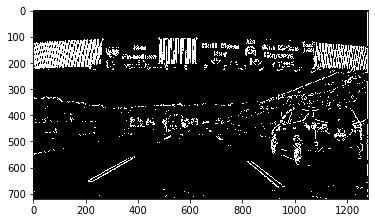

In [8]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
#combining results
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

In [9]:
#############################################################################
############################# COMBINED   ####################################
#############################################################################
def combined(img):

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    #combining results
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    binary_output = combined
    return (binary_output)

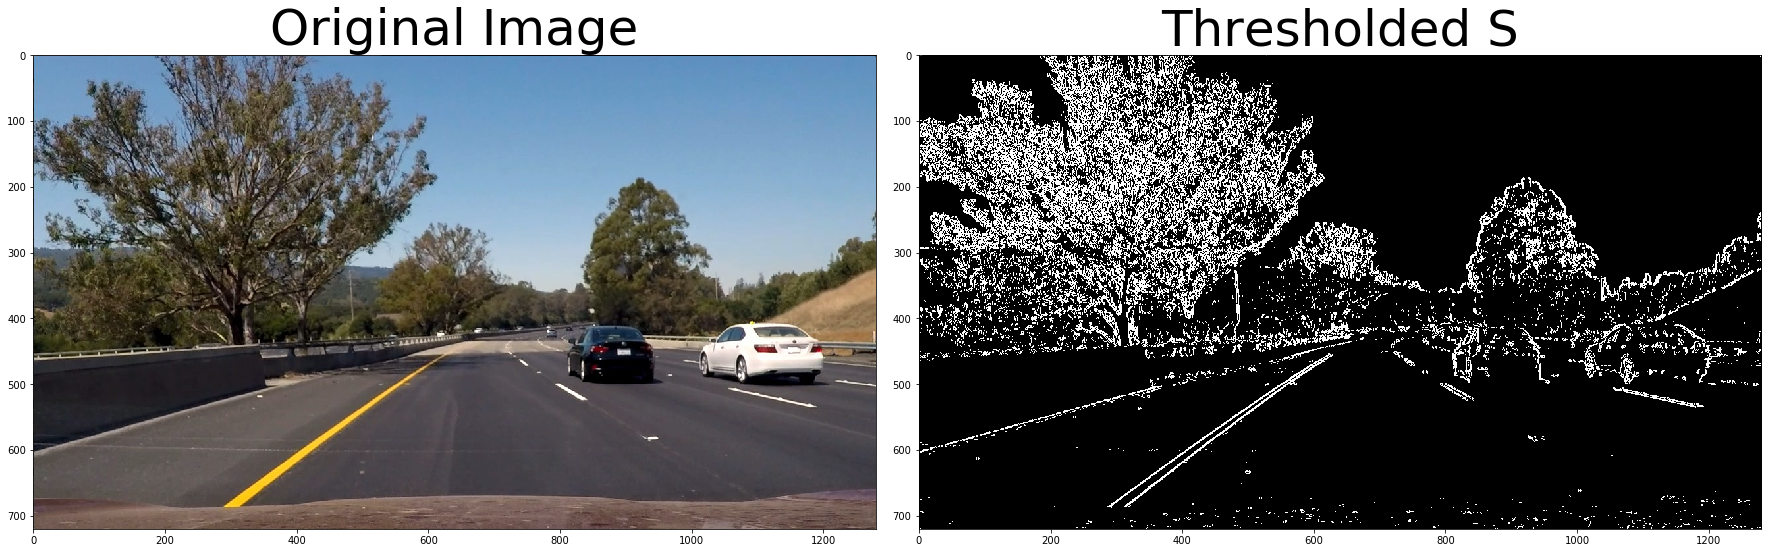

In [10]:
### TEST
image6 = mpimg.imread(folder + 'test6.jpg') 
hls_binary = combined(image6)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image6)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Apply a perspective transform ("birds-eye view").

In [11]:
#############################################################################
########################### BIRD'S EYE VIEW #################################
#############################################################################
def perspective_transform(image):
    # hiperparameters
    top_right = (723, 453)
    top_left = (556, 456)
    botom_right = (1285, 685)
    botom_left = (0, 680)
    #extract image dimensions
    img_size = (img.shape[1], img.shape[0])
    #set source points
    src = np.float32([[top_right],[top_left],[botom_right],[botom_left]])
    #define width and height
    w, h = img.shape[1], img.shape[0]
    #set destination points
    dst = np.float32([[w,0],[0,0],[w,h],[0,h]])
    # get a perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # get inverse matrix
    unwrap_m = cv2.getPerspectiveTransform(dst, src)
    # warp original image
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix 
    return (warped, unwrap_m)

(720, 1280, 3)


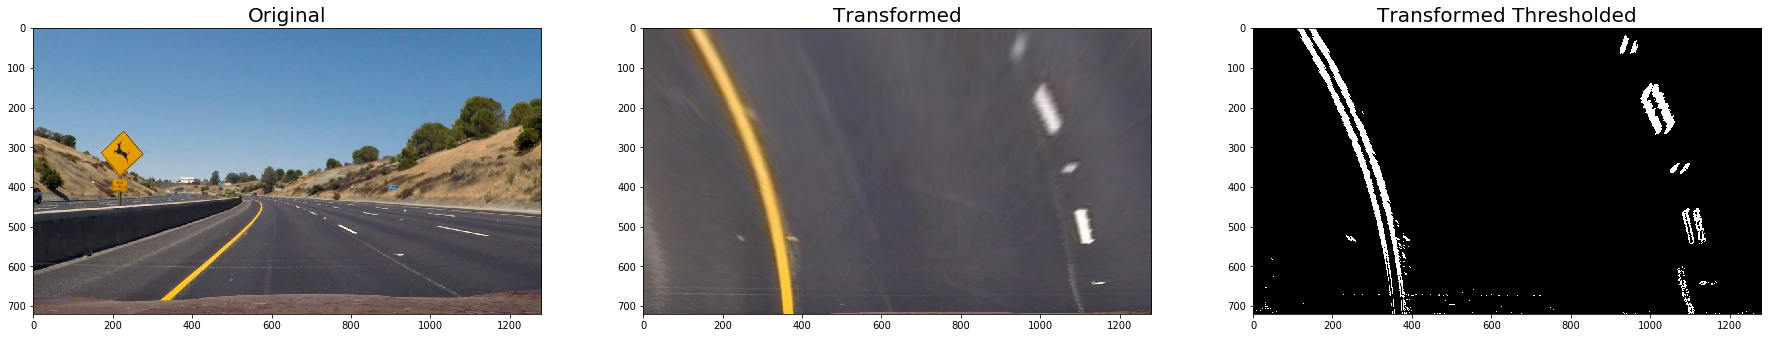

In [12]:
##############################################################
############## PLOT THE BIRD EYE VIEW ########################
##############################################################
imagen = mpimg.imread("test_images/test2.jpg")
img_size = imagen.shape
print(img_size)
transformed, unwrap_m = perspective_transform(imagen) 
hls_binary_transformed = combined(transformed)

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(imagen)
ax1.set_title('Original', fontsize=20)
ax2.imshow(transformed, cmap = "gray")
ax2.set_title('Transformed', fontsize=20)
ax3.imshow(hls_binary_transformed, cmap='gray')
ax3.set_title('Transformed Thresholded', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Detect lane pixels

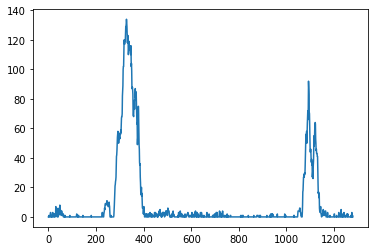

In [13]:
import numpy as np
histogram = np.sum(hls_binary_transformed[hls_binary_transformed.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [14]:
########################################################################
########################### FIT POLY ###################################
########################################################################
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() 
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty
########################################################################
######################## SEARCH AROUND POLY ############################
########################################################################
def search_around_poly(binary_warped):

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    ## End visualization steps ##
    
    return (result,left_fitx,right_fitx,ploty)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


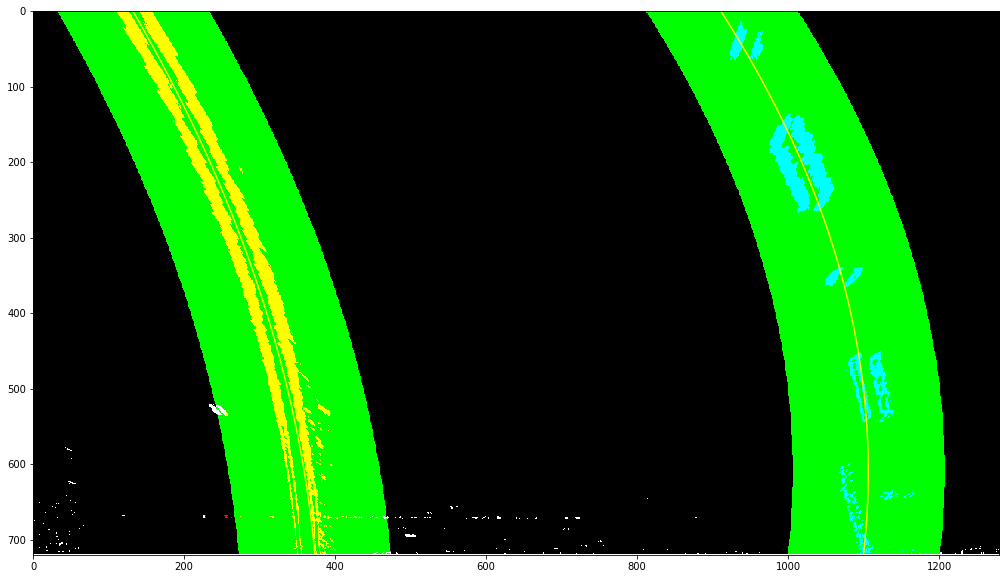

In [15]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,left_x_predictions, right_x_predictions,_= search_around_poly(hls_binary_transformed)

# View your output
plt.imshow(result)

# The pipeline 

In [16]:
def pipeline(img):
    img_size = img.shape
    und_img = cal_undistort(img, objpoints, imgpoints)
    transformed, unwrap_m = perspective_transform(und_img) 
    hls_binary_transformed = combined(transformed)

    histogram = np.sum(hls_binary_transformed[int(hls_binary_transformed.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((hls_binary_transformed, hls_binary_transformed, hls_binary_transformed))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(hls_binary_transformed.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = hls_binary_transformed.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = hls_binary_transformed.shape[0] - (window+1)*window_height
        win_y_high = hls_binary_transformed.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/730 # meters per pixel in x dimension

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(hls_binary_transformed.shape, leftx, lefty, rightx, righty)
    
    y_eval = np.max(ploty)
    ############################################################################################
    ############ Determine the curvature and vehicle position with respect to center.###########
    ############################################################################################
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #radius
    average_curve_rad = (left_curverad + right_curverad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    # center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs



    # Create an image to draw the lines on
    warp_zero = np.zeros_like(hls_binary_transformed).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    ##################################################################################################
    ############# Draw in the image the detected lines ###############################################
    ##################################################################################################
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, unwrap_m, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    # Creating Text and set font parameters
    TextL = curvature_string
    TextR = offset_string
    fontScale=1.5
    thickness=3
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, TextR, (110,110), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    resultado = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return resultado


## Output visual display

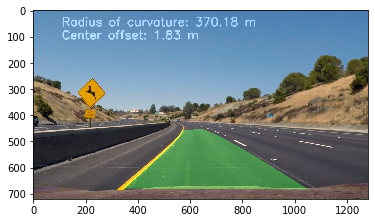

In [17]:
imagen = mpimg.imread("test_images/test2.jpg")
re = pipeline(imagen)
plt.imshow(re)

# Output visual display in a video


In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve
#Create video file pipeline
output = 'out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

Moviepy - Building video out_test_video.mp4.
Moviepy - Writing video out_test_video.mp4



Moviepy - Done !
Moviepy - video ready out_test_video.mp4
Wall time: 41min 18s


### the moment of truth

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))